In [ ]:
Threads.nthreads() = 2

In [1]:
include("ftdt_mirror.jl")
using .ftdt
using ProgressBars

########################################################################
# Se define la geometría en la ventana numérica principal
#######################################################################
und = 1*10^-6;                       # Unidad espacial
unt = 1*10^0;                       # Unidad temporal

epsz = (8.854187817*10^-12)*((und^3)/(unt^4)); 
muz = (4*pi*1e-7)*((unt^2)/und);
etaz=sqrt(muz/epsz);
cc =  sqrt(1/(epsz*muz));

freq=7.5e+14*(unt);                        # Frecuencia de la fuente de campo
lambda=cc/freq;  
@show lambda, cc
# Longitud de onda de la fuente de campo 
omega=2.0*pi*freq;                  # Frecuencia en radiandes

dx = lambda/10;#(100e-3)*und;                             # Diferencial espacial

ventNum = round.([30*10^-3 15*10^-3]/und*dx,RoundUp);

@show ventNum

ie= Int(ventNum[2]);                                     # nodos en y
je= Int(ventNum[1]);  

"""
COSOS
"""


CFL = 0.99                          # Constante de Courant
dt = CFL / (cc * sqrt((1/dx^2) + (1/dx^2)))  # Diferencial temporal

@show dt

tau = Int(round(1 / freq / dt)) ;    # Nodos por periodo
nmax = tau * 90         ;            # Cantidad total de nodos temporales
ie = Int(round.(15e-3 / und * dx, RoundUp));   # nodos en y
je = Int(round.(30e-3 / und * dx, RoundUp));   # nodos en x
nx = je;
ny = ie;
nt = nmax;

@show nt, nx, ny

# Se agregan objetos en el medio

idx = 1:je;
idy = 1:ie;
medioProp = epsz;
mirrorMatrix = zeros(Int, ie, je);

@show size(mirrorMatrix)





(lambda, cc) = (0.3997232773473371, 2.997924580105028e14)
ventNum = [1200.0 600.0]
dt = 9.333809511662429e-17
(nt, nx, ny) = (840, 1200, 600)
size(mirrorMatrix) = (600, 1200)


(600, 1200)

In [2]:
# Define grid dimensions
width = 1200  # Width of the grid
height = 600  # Height of the grid

# Define ellipse properties
n_ellipse = 1.5168  # Refractive index of the ellipse
a = 100  # Semi-major axis
b = 200  # Semi-minor axis
center_x = div(width, 2)  # Center of the ellipse (x-coordinate)
center_y = div(height, 2)  # Center of the ellipse (y-coordinate)

# Initialize the medium properties matrix with background index
n = ones(height, width)

# Calculate the ellipse profile and assign the refractive index
for y in 1:height
    for x in 1:width
        if ((x - center_x)^2 / a^2 + (y - center_y)^2 / b^2) <= 1
            n[y, x] = n_ellipse
        end
    end
end

medioProp = epsz * n



@show size(medioProp)


size(medioProp) = (600, 1200)


(600, 1200)

In [6]:
# Lente de Luneburg
f = 0.7;
# Define the center of the grid
centr = [div(600,2), div(1201,2)];
# New radius defined as half the height of the grid
rad = 200;

# Adjust indices to cover new radius
idx = centr[2]-rad:centr[2]+rad;
idy = centr[1]-rad:centr[1]+rad;

# Define domain
domx = dx * collect(idx);
domy = dx * collect(idy);
aux = length(domx);

# Recalculate radial domain and refractive index
domR = sqrt.((ones(aux,1) .* domx' .- centr[2]*dx).^2 + ((ones(1,aux) .* domy) .- centr[1]*dx).^2);
n = real.((1/f) * sqrt.(Complex.(1 .+ f^2 .- (domR ./ rad * dx).^2)));
n[domR .> rad*dx] .= 1;
medioProp = epsz * (n.^2);

@show size(medioProp)

size(medioProp) = (401, 401)


(401, 401)

## SQUARE MIRROR

In [2]:
# Recalculate the center and size to fit within the new dimensions
centerX = Int(round(size(mirrorMatrix, 2) / 2))
centerY = Int(round(size(mirrorMatrix, 1) / 2))
mirrorSize = Int(round(min(size(mirrorMatrix, 1), size(mirrorMatrix, 2)) / 50))

# Define start and end indices for the mirror
startX = centerX - Int(round(mirrorSize / 2))
endX = centerX + Int(round(mirrorSize / 2))
startY = centerY - Int(round(mirrorSize / 2)*10)
endY = centerY + Int(round(mirrorSize / 2)*10)

# Ensure indices are within bounds
startX = max(startX, 1)
startY = max(startY, 1)
endX = min(endX, size(mirrorMatrix, 2))
endY = min(endY, size(mirrorMatrix, 1))

# Set mirror region to 1
mirrorMatrix[startY:endY, startX:endX] .= 1

# Confirm the size and position
@show startX, endX, startY, endY



(startX, endX, startY, endY) = (594, 606, 240, 360)


(594, 606, 240, 360)

## DIAGONAL MIRROR

In [3]:


function apply_mirror!(mirrorMatrix, x1, y1, x2, y2, T)
    # Line equation coefficients A, B, and C (Ax + By + C = 0)
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2

    # Function to calculate distance from point (x, y) to line Ax + By + C = 0
    function point_to_line_distance(x, y, A, B, C)
        return abs(A * x + B * y + C) / sqrt(A^2 + B^2)
    end

    # Function to check if point (x, y) is between (x1, y1) and (x2, y2)
    function is_point_within_segment(x, y, x1, y1, x2, y2)
        min_x = min(x1, x2)
        max_x = max(x1, x2)
        min_y = min(y1, y2)
        max_y = max(y1, y2)
        return x >= min_x && x <= max_x && y >= min_y && y <= max_y
    end

    # Iterate over each point in the mirrorMatrix
    for x in 1:size(mirrorMatrix, 2)
        for y in 1:size(mirrorMatrix, 1)
            # Check if the point is within the thickness of the line and within the segment
            if point_to_line_distance(x, y, A, B, C) <= T / 2 && is_point_within_segment(x, y, x1, y1, x2, y2)
                mirrorMatrix[y, x] = 1
            end
        end
    end

    # Optional: Display positions where mirrorMatrix is 1
    @show findall(x -> x == 1, mirrorMatrix);
end

# Define start and end points and thickness
x1, y1 =  600, 500       # Start point of the diagonal mirror
x2, y2 =  500, 600 # End point, can be adjusted
T = 10                # Thickness of the mirror

# Apply the mirror to the mirrorMatrix
apply_mirror!(mirrorMatrix, x1, y1, x2, y2, T);

# Define start and end points and thickness
x1, y1 =  600, 100       # Start point of the diagonal mirror
x2, y2 =  500, 0 # End point, can be adjusted
T = 10                # Thickness of the mirror

# Apply the mirror to the mirrorMatrix
apply_mirror!(mirrorMatrix, x1, y1, x2, y2, T);



findall((x->begin
            #= In[3]:34 =#
            x == 1
        end), mirrorMatrix) = CartesianIndex{2}[CartesianIndex(593, 500), CartesianIndex(594, 500), CartesianIndex(595, 500), CartesianIndex(596, 500), CartesianIndex(597, 500), CartesianIndex(598, 500), CartesianIndex(599, 500), CartesianIndex(600, 500), CartesianIndex(592, 501), CartesianIndex(593, 501), CartesianIndex(594, 501), CartesianIndex(595, 501), CartesianIndex(596, 501), CartesianIndex(597, 501), CartesianIndex(598, 501), CartesianIndex(599, 501), CartesianIndex(600, 501), CartesianIndex(591, 502), CartesianIndex(592, 502), CartesianIndex(593, 502), CartesianIndex(594, 502), CartesianIndex(595, 502), CartesianIndex(596, 502), CartesianIndex(597, 502), CartesianIndex(598, 502), CartesianIndex(599, 502), CartesianIndex(600, 502), CartesianIndex(590, 503), CartesianIndex(591, 503), CartesianIndex(592, 503), CartesianIndex(593, 503), CartesianIndex(594, 503), CartesianIndex(595, 503), CartesianIndex(596, 503), Cart

In [ ]:
# Columan de lentes de Luneburg
nL = 5;
rad = 60; #div(ie-101,nL);
f = 1;
#f = 1.5*rad;

auxCr = (2*rad.*[collect(-div(nL-1,2):1:div(nL-1,2)) zeros(nL,1)])
ctrA = [div(ie,2) div(je,4)];
centr = ones(nL,1).*ctrA;
centr[:,1] = centr[:,1].+auxCr[:,1];
centr[:,2] = centr[:,2].+auxCr[:,2];
centr = Int.(centr);

n = zeros(ie,je);
for itl = 1:nL
  idx = centr[itl,2]-rad-1:centr[itl,2]+rad-1;
  idy = centr[itl,1]-rad-1:centr[itl,1]+rad-1;
  
  domx = dx*collect(idx);
  domy = dx*collect(idy);
  aux = length(domx);
  
  domR = sqrt.( ((ones(aux,1).*domx').-centr[itl,2]*dx).^2 + ((ones(1,aux).*domy).-centr[itl,1]*dx).^2 );
  nAux = real.((1/f)* sqrt.(Complex.( (1).+(f^2).-((domR./rad*dx).^2) )));
  #alf = 0.74;
  #nAux = real.((1/f)* sqrt.(Complex.( (rad^2).+(f^2).-alf*(domR.^2) )));
  n[idy,idx] = n[idy,idx].+nAux.*(domR.<rad*dx);
end
n[n.==0].=1;
idx = 1:je;
idy = 1:ie;
medioProp = epsz*(n.^2);

# save(File(format"JLD",string(pwd(),"\\gifMagico\\casoMaterialLuneburg.jld")),"caso",casoMaterial,"f",f,"rad",rad,"centr",centr)


size(medioProp) = (600, 1200)


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


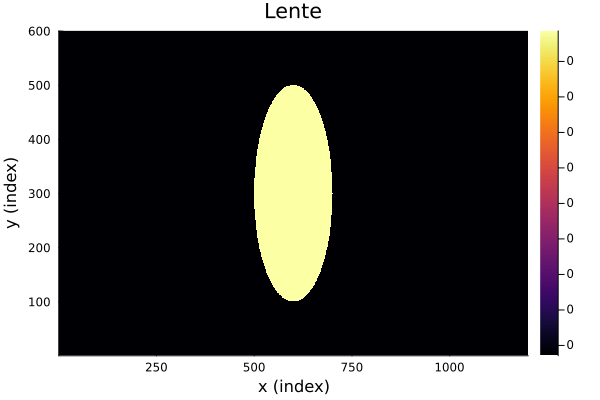

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [7]:
using Plots
gr()

grafZoom2 = plot(layout=grid(1,1), colorbar=:top)

@show size(medioProp)

# heatmap!(combinedMatrix, title="Index of Refraction - Luneburg Lens", color=:viridis, xlabel="x (m)", ylabel="y (m)")
heatmap!(medioProp, title="Lente", xlabel="x (index)", ylabel="y (index)")
# savefig("luneburg_lens_heatmap.png")  # Save the Luneburg lens heatmap

display(grafZoom2)

size(medioProp) = (600, 1200)
size(mirrorMatrix) = (600, 1200)


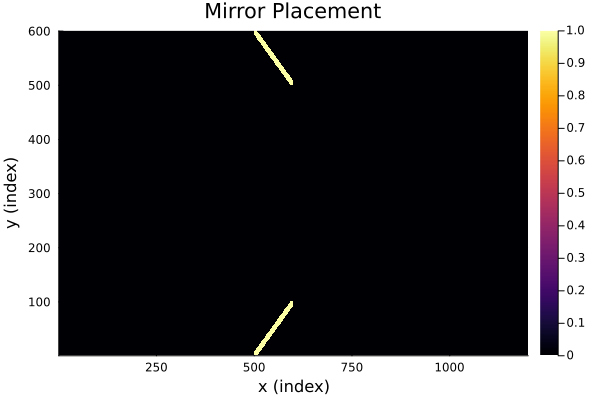

In [6]:
using Plots
gr()
# Plotting the index of refraction
grafZoom2 = plot(layout=grid(1,1), colorbar=:top)


@show size(medioProp)
@show size(mirrorMatrix)
# pop last line of medioProp

combinedMatrix = (medioProp .+ mirrorMatrix).^100

# heatmap!(combinedMatrix, title="Index of Refraction - Luneburg Lens", color=:viridis, xlabel="x (m)", ylabel="y (m)")
heatmap!(combinedMatrix, title="Mirror Placement", xlabel="x (index)", ylabel="y (index)")
# savefig("luneburg_lens_heatmap.png")  # Save the Luneburg lens heatmap

display(grafZoom2)

In [4]:
matrices = simular(medioProp, mirrorMatrix, idx, idy, nmax, freq, dx, dt);

Declaración de constantes físicas
Declaración de parámetros computacionales
Velocidad de la luz: 2.998e+14 
Longitud de onda: 3.997e-07 
Unidad de distancia: 1.000e-06 
Unidad de tiempo: 1.000e+00 
Diferencial de distancia: 3.997e-02 
Diferencial de tiempo: 9.334e-17 
Cantidad de nodos temporales: 840 
Cantidad de nodos en x: 600 
Cantidad de nodos en y: 1200 
Declaración de matrices
Definición de geometría
size(cbex) = (600, 1201)
Inicia Propagación


0.0%┣                                              ┫ 0/840 [00:00<00:-2, -0s/it]
0.1%┣                                          ┫ 1/840 [00:00<Inf:Inf, InfGs/it]
0.2%┣▏                                              ┫ 2/840 [00:00<05:47, 2it/s]
0.4%┣▏                                              ┫ 3/840 [00:00<03:15, 4it/s]
0.5%┣▎                                              ┫ 4/840 [00:01<02:37, 5it/s]
0.7%┣▍                                              ┫ 6/840 [00:01<01:55, 7it/s]
1.0%┣▌                                              ┫ 8/840 [00:01<01:31, 9it/s]
1.2%┣▌                                            ┫ 10/840 [00:01<01:17, 11it/s]
1.4%┣▋                                            ┫ 12/840 [00:01<01:09, 12it/s]
1.7%┣▊                                            ┫ 14/840 [00:01<01:07, 12it/s]
1.8%┣▉                                            ┫ 15/840 [00:01<01:08, 12it/s]
2.0%┣█                                            ┫ 17/840 [00:01<01:02, 13it/s]
2.3%┣█                      

In [5]:
using Plots, Colors
using FileIO
#using CairoMakie, Colors            # Graficas
#CairoMakie.activate!(type = "svg")
direc = "/home/jay/Photonics/FTDTgifMagico"

# Vista previa de objeto
fsx = (1/dx)*und;
fsy = (1/dx)*und;
domx = fsx*collect(1:nx);
domy = fsy.*collect(1:ny);

# Debes asegurarte que nx y ny son enteros
nx = Int(round(nx))
ny = Int(round(ny))

# Ahora puedes usar nx y ny para definir tus matrices
initial_info = matrices[Int(nt)]

ny, nx = size(initial_info)
inte = zeros(ny, nx)

for itint in ProgressBar(1:nmax-1)
        index = Int(nt-itint)
        info = matrices[index]
        info = info./maximum(info);
        inte = inte .+ abs.(info).^2;
end

# Skectch final
ref = 1;
itn = Int(nt);#nt; 
info = matrices[itn];
info = info./maximum(info);
deltaY = domy[2] - domy[1];  # Assuming uniform spacing, find the step
domy = [domy; domy[end] + deltaY];  # Append a new value that continues the interval



0.0%┣                                              ┫ 0/839 [00:00<00:00, -0s/it]
0.1%┣                                          ┫ 1/839 [00:00<Inf:Inf, InfGs/it]
1.5%┣▊                                            ┫ 13/839 [00:00<00:17, 49it/s]
5.1%┣██▎                                         ┫ 43/839 [00:00<00:06, 141it/s]
8.7%┣███▉                                        ┫ 73/839 [00:00<00:04, 207it/s]
12.3%┣█████▏                                    ┫ 103/839 [00:00<00:03, 256it/s]
15.9%┣██████▋                                   ┫ 133/839 [00:00<00:02, 293it/s]
19.4%┣████████▏                                 ┫ 163/839 [00:01<00:02, 323it/s]
23.0%┣█████████▋                                ┫ 193/839 [00:01<00:02, 347it/s]
26.6%┣███████████▏                              ┫ 223/839 [00:01<00:02, 368it/s]
30.2%┣████████████▋                             ┫ 253/839 [00:01<00:02, 385it/s]
33.7%┣██████████████▏                           ┫ 283/839 [00:01<00:01, 399it/s]
37.3%┣███████████████▊      

In [ ]:

plotly()  # Using Plotly for interactive plots, or choose another backend like gr()

# Initialize the plotting
grafZoom2 = plot(layout=grid(1,1), colorbar=:top)

# Adding heatmap to the plot
heatmap!(grafZoom2[1], domx, domy, (1/1740) .* inte, colorbar=:top, xlabel="x [mts]", ylabel="y [mts]",
         title="Intensidad", aspect_ratio=:equal,
         # Uncomment and modify the following lines as needed
         # xlims=(limX[1], limX[2]), ylims=(limY[1], limY[2]),
         c = :berlin)

# Uncomment if you want to add additional plot features, such as overlaying lines
# plot!(grafZoom2[1], fsx*materiales[1]*cos.(th) .+ centr[2]*fsx, materiales[1]*fsx*sin.(th) .+ centr[1]*fsx,
#       label=false, linecolor=:black, linewidth=1)

# Display the plot in the notebook
display(grafZoom2)


In [ ]:

grafFinal = heatmap(domx,domy,info,clims=(-ref,ref),xlabel="x [mts]",ylabel="y [mts]",
                    aspect_ratio=:equal,
                    xlims=(0,fsx*nx),ylims=(0,fsy*ny),
                    c = :berlin
                    )
# plot!(grafFinal,fsx*materiales[1]*cos.(th).+centr[2]*fsx, materiales[1]*fsx*sin.(th).+centr[1]*fsx,label=false,
#                     linecolor=:white ,linewidth=0.5
#                     )
annotate!(grafFinal,[(0.026,0.014,(string("Iteración: ",itn),10,:white))])
annotate!(grafFinal,[(0.026,0.001,(string("t= ",round(itn*dt*unt,digits=16)," s"),10,:white))])

display(grafFinal)


0.0%┣                                               ┫ 0/17 [00:00<00:00, -0s/it]
5.9%┣██▌                                        ┫ 1/17 [00:02<Inf:Inf, InfGs/it]
11.8%┣█████▌                                         ┫ 2/17 [00:03<00:40, 3s/it]
17.6%┣████████▎                                      ┫ 3/17 [00:03<00:21, 1s/it]
23.5%┣███████████                                    ┫ 4/17 [00:03<00:15, 1s/it]
29.4%┣█████████████▉                                 ┫ 5/17 [00:04<00:11, 1it/s]
35.3%┣████████████████▋                              ┫ 6/17 [00:04<00:09, 1it/s]
41.2%┣███████████████████▍                           ┫ 7/17 [00:04<00:07, 1it/s]
47.1%┣██████████████████████▏                        ┫ 8/17 [00:05<00:06, 1it/s]
52.9%┣████████████████████████▉                      ┫ 9/17 [00:05<00:05, 2it/s]
58.8%┣███████████████████████████                   ┫ 10/17 [00:06<00:04, 2it/s]
64.7%┣█████████████████████████████▊                ┫ 11/17 [00:06<00:04, 2it/s]
70.6%┣██████████████████████

Plots.AnimatedGif("/home/jay/Photonics/FTDT/animation.gif")
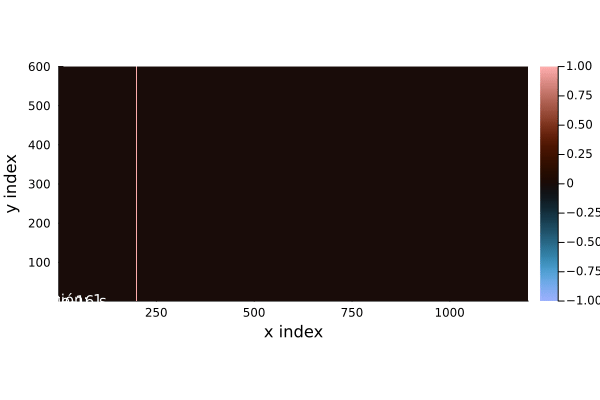

In [6]:
gr()  # Switch to GR backend for better handling of animations

# Function to create and display an animation in the notebook
function display_animation(matrices, fsx, fsy)

    # IT IS SLOOOOOW
    key_subset = sort(collect(keys(matrices)))[1:50:end]
    
    
    anim = @animate for itn in ProgressBar(key_subset)
        info = matrices[itn]
        info = info ./ maximum(info)

        nrows, ncols = size(info)

        grafFinal = heatmap(1:ncols, 1:nrows, info, clims=(-1, 1), xlabel="x index", ylabel="y index",
                            aspect_ratio=:equal,
                            xlims=(1, ncols), ylims=(1, nrows),
                            c = :berlin)

        # Annotations for iteration number and time
        annotate!(grafFinal, [(5, 5, ("Iteración: $itn", 10, :white))])
        annotate!(grafFinal, [(5, 2, ("t= $(round(itn*dt*unt, digits=16)) s", 10, :white))])
    end
    gif(anim, "animation.gif", fps = 120)  # Adjust fps according to your preference
end

# Call the function to create and display the animation in the notebook
animation = display_animation(matrices, fsx, fsy)


In [ ]:


# Zoom en la frontera de los lentes
ref = 1;
itn = nt;#nt;
info = matrices;
# info = info./maximum(info);
limY = fsx*round.( [centr[1]-1.5materiales[1],centr[1]+1.5materiales[1]],RoundUp);
limX = fsx*round.( [centr[2]-1.5materiales[1],centr[2]+1.5materiales[1]],RoundUp);

grafZoom1 = plot(layout=grid(1,1),colorbar=:top,clims=(-ref,ref))
heatmap!(grafZoom1[1],domx,domy,info,colorbar=:top,xlabel="x [mts]",ylabel="y [mts]",
        title="Campo Hz",aspect_ratio=:equal,
        xlims=(limX[1],limX[2]),ylims=(limY[1],limY[2]),
        c = :berlin
        );
plot!(grafZoom1[1],fsx*materiales[1]*cos.(th).+centr[2]*fsx, materiales[1]*fsx*sin.(th).+centr[1]*fsx,label=false,
        linecolor=:white ,linewidth=1
        );
savefig(grafZoom1,string("campoHz",numCarp,".pdf"))

# Cortes Transversales
ref = 1;
itn = nt;#nt;
refT = round(itn*dt*unt,digits=16);
info = load( string(direc,"\\matHz-",itn,".jld"), "hz");
info = info./maximum(info);
inte = abs.(info).^2;

grafCT = plot(layout=grid(2,1))
plot!(grafCT[1],domx,info[div(ny,2),:],aspect_ratio=:auto,xlims=(0,nx*fsx),ylims=(-1,1),
        title="Amplitud Campo Hz",xlabel="x [mts]",ylabel="Amplitud",label = string("t=",refT," s"),
        linecolor=:purple)
plot!(grafCT[2],domx,inte[div(ny,2),:],aspect_ratio=:auto,xlims=(0,nx*fsx),ylims=(0,1),
        title="Intensidad Campo Hz",xlabel="x [mts]",ylabel="Intensidad",label = string("t=",refT," s"),
        linecolor=:purple)

savefig(grafCT,string("campoHz",numCarp,"_CT.pdf"))

# Creación del gif
ref = 1;
@time begin
anim = @animate for itn = 1:4:nt
    info = load( string(direc,"\\matHz-",itn,".jld"), "hz");
    info = info./maximum(info);
    grafFinal = heatmap(domx,domy,info,clims=(-ref,ref),xlabel="x [mts]",ylabel="y [mts]",
                        aspect_ratio=:equal,
                        xlims=(0,fsx*nx),ylims=(0,fsy*ny),
                        c = :berlin
                        )
    plot!(grafFinal,fsx*materiales[1]*cos.(th).+centr[2]*fsx, materiales[1]*fsx*sin.(th).+centr[1]*fsx,label=false,
                        linecolor=:white ,linewidth=0.5
                        )
    annotate!(grafFinal,[(0.026,0.014,(string("Iteración: ",itn),10,:white))])
    annotate!(grafFinal,[(0.026,0.001,(string("t= ",round(itn*dt*unt,digits=16)," s"),10,:white))])
end
end

gif(anim,string("anim",numCarp,".gif"), fps = 120)